Задание. Необходимо найти решение интегрированной модели актива в конфигурации пласт + скважина + сеть сбора и траснпорта. Входные данные для решения интегрированной модели актива представлены в виде функции IPR кривой для каждой скважины, параметры притока, VLP-таблиц (определяющий перепад давлений на скважиназ (забой-устье), VLP-таблицы трубопроводов, давление на УПН.

![image.png](attachment:cf7b9e17-2032-415e-bb95-46707d32a64a.png)

In [38]:
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
from scipy import interpolate
import scipy.optimize
import time
import matplotlib.pyplot as plt

In [39]:
# функция входных данных по продуктивности для каждой скважины
def fProductivity(well):
    K_prod = {'W1': 0.14,
              'W2': 0.22,
              'W3': 0.4,
              'W4': 0.05,
              'W5': 0.8,
              'W6': 0.5}
    return K_prod[well]

# функция входных данных по частоте насоса в скважинах
def fPump(well):
    K_prod = {'W1': 35,
              'W2': 36,
              'W3': 35,
              'W4': 43,
              'W5': 35,
              'W6': 35}
    return K_prod[well]

# функция входных данных по обводненности для каждой скважины
def fWCT(well):
    WCT_w = {'W1': 0.50,
             'W2': 0.30,
             'W3': 0.22,
             'W4': 0.44,
             'W5': 0.12,
             'W6': 0.77}
    return WCT_w[well]

# функция входных данных по газовому фактору для каждой скважины
def fGOR(well):
    GOR_w = {'W1': 120,
             'W2': 230,
             'W3': 211,
             'W4': 157,
             'W5': 144,
             'W6': 160}
    return GOR_w[well]

# функция входных данных по давлению пласта для каждой скважины (давление на контуре)
def fReservoir_pressure(well):
    Reservoir_pressure = {'W1': 200,
                          'W2': 190,
                          'W3': 240,
                          'W4': 230,
                          'W5': 185,
                          'W6': 160}
    return Reservoir_pressure[well]

# функция входных данных по топологии сети сбора и транспорта
def find_joint_neighbour(joint):
    Joints = {'W1' : 'J1',
              'W2' : 'J1',
              'W3' : 'J1',
              'W4' : 'J2',
              'W5' : 'J2',
              'W6' : 'J2',
              'J1' : 'J3',
              'J2' : 'J3',
              'J3' : 'Separator',}
    return Joints[joint]

# the fuction for find wells in structure (UPN -> wells)
def find_included_well(joint):

    well_list = {'Separator' : ['W1', 'W2', 'W3', 'W4', 'W5', 'W6'],
                 'J3' : ['W1', 'W2', 'W3', 'W4', 'W5', 'W6'],
                 'J2' : ['W4', 'W5', 'W6'],
                 'J1' : ['W1', 'W2', 'W3']}

    return well_list[joint]

Необходимо описать функцию притока скважины в виде IPR кривой.
![image.png](attachment:3173ab86-7694-4f32-8b80-845f1a1936ac.png)

In [40]:
# функция определения дебита
def rate_calculation(PI, Pres, Pw):
    # PI - индекс продуктивности
    # Pres - Ддавление пласта
    # Pw - Well bottom pressure
    # Pb - давление насыщения нефти
    Pb = 100
    if Pw > Pb: rate = PI*(Pres - Pw)
    else:
        rate_Pb = PI * (Pres - Pb)
        rate = rate_Pb + PI * Pb / 1.8 * ( 1 - 0.2 * (Pw / Pb) - 0.8 * (Pw / Pb)**2 )
    #print(rate)
    return rate

In [41]:
P = [200, 175, 150, 125, 100, 75, 50, 25, 0]
rate = [rate_calculation(fProductivity('W2'), fReservoir_pressure('W1'), x) for x in P]
rate

[0.0,
 5.5,
 11.0,
 16.5,
 22.0,
 26.88888888888889,
 30.555555555555554,
 33.0,
 34.22222222222222]

Text(0, 0.5, 'BHP')

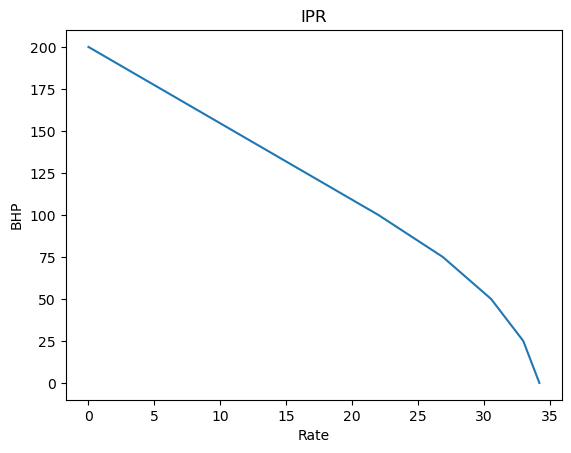

In [42]:
plt.plot(rate, P)

plt.title('IPR')
plt.xlabel('Rate')
plt.ylabel('BHP')

In [43]:
# Суммирование дебита по узлам
def parameters_in_joint(joint, Pw):

    well_list = find_included_well(joint)
    Joint_rate = 0
    Joint_water = 0
    Joint_gas = 0

    for well in well_list:
        Liquid_rate = rate_calculation(fProductivity(well),
                                       fReservoir_pressure(well),
                                       Pw[well])
        Water_rate = fWCT(well)*Liquid_rate
        Gas_rate = fGOR(well)*(Liquid_rate - Water_rate)
        Joint_rate += Liquid_rate
        Joint_water += Water_rate
        Joint_gas += Gas_rate
    WCT = Joint_water / Joint_rate
    GOR = Joint_gas / (Joint_rate - Joint_water)
    Parameters = {'Rate' : Joint_rate,
                  'WCT' : WCT,
                  'GOR' : GOR,
                  'Pressure' : 0}

    return Parameters

![image.png](attachment:22864d05-049e-4adf-a893-493417b7969f.png)

In [44]:
# Интерполятор VLP таблицы скважины
def interpolator_well(df):
    THP = np.unique(df['THP'])
    WCT = np.unique(df['WCT'])
    GOR = np.unique(df['GOR'])
    LIQ = np.unique(df['LIQ'])
    PUMP = np.unique(df['PUMP'])
    BHP = df['BHP'].values.reshape(len(WCT), len(THP), len(GOR), len(PUMP), len(LIQ))

    interpolator = RegularGridInterpolator((WCT, THP, GOR, PUMP, LIQ), BHP, method='linear', bounds_error=False, fill_value=None)

    return interpolator

In [45]:
# Интерполятор трубопроводов
def interpolator(df):
    THP = np.unique(df['THP'])
    WCT = np.unique(df['WCT'])
    GOR = np.unique(df['GOR'])
    LIQ = np.unique(df['LIQ'])
    BHP = df['BHP'].values.reshape(len(GOR), len(WCT), len(THP), len(LIQ))
    
    interpolator = RegularGridInterpolator((GOR, WCT, THP, LIQ), BHP, method='linear', bounds_error=False, fill_value=None)
    return interpolator

![image.png](attachment:511a444e-a86f-44ad-badb-935de1313781.png)

In [46]:
Joints = ['Separator', 'J3', 'J2', 'J1']
Wells = ['W1', 'W2', 'W3', 'W4', 'W5', 'W6']
Pressure = 15
df = pd.read_csv('VFP.csv', sep = ';')
df_well = pd.read_csv('VFP_well.csv', sep = ';')
bounds = ([1, 150], [1, 150], [1, 150], [1, 150], [1, 150], [1, 150])
first_values = [50, 50, 50, 50, 50, 50]

In [47]:
# Метод расчета итераций найденнызх забойных давлений
def search_p(x0):
    mistake = 1
    k = 0
    while mistake > 0.1 and k < 200:
        #print('----------- calculation ----------\n')
        # давления на забое скважины как начальные параметры для расчета системы
        Pw = {'W1': x0[0],
              'W2': x0[1],
              'W3': x0[2],
              'W4': x0[3],
              'W5': x0[4],
              'W6': x0[5]}
        print(Pw)
        Pressure_joint = dict()
        interpolated_value = interpolator(df)

        # определение давлений в узлах сети сбора и транспорта
        for joint in Joints:

            Parameters = parameters_in_joint(joint, Pw)

            if joint == 'Separator':
                Parameters['Pressure'] = Pressure
            else:
                neighbour = find_joint_neighbour(joint)
                Parameters['Pressure'] = Pressure_joint[neighbour]
            point = [Parameters['GOR'], Parameters['WCT'],  Parameters['Pressure'], Parameters['Rate']] # GOR, WCT, THP, LIQ
            Parameters['Pressure'] = interpolated_value(point)[0]
            Pressure_joint[joint] = Parameters['Pressure']
            print(joint, Parameters)

        mistake = 0
        BHP_list = []
        interpolated_value_well = interpolator(df_well)

        # определение давлений на устье и забое скважины
        for well in Wells:
            neighbour = find_joint_neighbour(well)
            THP = Pressure_joint[neighbour]
            rate =rate_calculation(fProductivity(well), fReservoir_pressure(well), Pw[well])
            point = [fGOR(well), fWCT(well), THP, rate]  # GOR, WCT, THP, LIQ
            Well_pressure = interpolated_value(point)[0]
            point = [fWCT(well), Well_pressure, fGOR(well), fPump(well), rate] # WCT, THP, GOR, PUMP, LIQ
            interpolated_value_well = interpolator_well(df_well)
            Well_BHP = interpolated_value_well(point)[0]
            print('well', 'THP', 'WCT', 'GOR', 'Pump', "Rate", 'BHP')
            print(well, point, Well_BHP)
            mistake += abs(Well_BHP - Pw[well])
            BHP_list += [Well_BHP]
            #mistake_mistake = rate_calculation(fPI[well], Pres, Pw)
        print('Mistake = ', mistake, 'iteration = ', k)
        k+=1
        x0 = BHP_list

    return x0

In [48]:
first_values = [50, 50, 50, 50, 50, 50]

In [49]:
t1 = time.time()
search_p(first_values)
t2 = time.time()
t2-t1


{'W1': 50, 'W2': 50, 'W3': 50, 'W4': 50, 'W5': 50, 'W6': 50}
Separator {'Rate': 276.35555555555555, 'WCT': 0.3171719202315857, 'GOR': 172.9162648013048, 'Pressure': 18.31437846884193}
J3 {'Rate': 276.35555555555555, 'WCT': 0.3171719202315857, 'GOR': 172.9162648013048, 'Pressure': 21.20644699152252}
J2 {'Rate': 157.0, 'WCT': 0.34191790516631276, 'GOR': 146.3561142955467, 'Pressure': 21.89299732715056}
J1 {'Rate': 119.35555555555555, 'WCT': 0.2846211133867064, 'GOR': 205.05520131171434, 'Pressure': 21.78263084393464}
well THP WCT GOR Pump Rate BHP
W1 [0.5, 21.783726741605253, 120, 35, 19.444444444444446] 120.91842529862599
well THP WCT GOR Pump Rate BHP
W2 [0.3, 21.810314671905488, 230, 36, 28.355555555555554] 70.000161251213
well THP WCT GOR Pump Rate BHP
W3 [0.22, 21.907247129301673, 211, 35, 71.55555555555556] 45.27885233507492
well THP WCT GOR Pump Rate BHP
W4 [0.44, 21.893514716671906, 157, 43, 8.444444444444445] 69.55739910113131
well THP WCT GOR Pump Rate BHP
W5 [0.12, 22.14859161

0.2379777431488037

In [ ]:
def search_p(x0, fPump):
    mistake = 10000
    k = 0
    while mistake > 0.1 and k < 200:
        Pw = {well: pressure for well, pressure in zip(Wells, x0)}
        Pressure_joint = {}

        interpolated_value = interpolator(df)
        interpolated_value_well = interpolator(df_well)

        for _ in range(10):
            for joint in Joints:
                Parameters = parameters_in_joint(joint, Pw)
                Parameters['Pressure'] = Pressure_joint.get(find_joint_neighbour(joint), Pressure)
                point = [Parameters['GOR'], Parameters['WCT'], Parameters['Pressure'], Parameters['Rate']]
                Parameters['Pressure'] = interpolated_value(point)[0]
                Pressure_joint[joint] = Parameters['Pressure']

            mistake = 0
            BHP_list = []

            for well in Wells:
                neighbour = find_joint_neighbour(well)
                THP = Pressure_joint[neighbour]
                rate = rate_calculation(fProductivity(well), fReservoir_pressure(well), Pw[well])
                point = [fGOR(well), fWCT(well), THP, rate]
                Well_pressure = interpolated_value(point)[0]
                point = [fWCT(well), Well_pressure, fGOR(well), fPump(well), rate]
                Well_BHP = interpolated_value_well(point)[0]

                mistake += abs(Well_BHP - Pw[well])
                BHP_list.append(Well_BHP)

            k += 1
            x0 = BHP_list
            Pw = {well: pressure for well, pressure in zip(Wells, x0)}

    Parameters = parameters_in_joint('Separator', Pw)
    rate_oil = Parameters['Rate'] * (1 - Parameters['WCT'])

    if all(x < 30 for x in x0):
        return -rate_oil

    return rate_oil

In [ ]:
def optimize_Freq(x1):
    print('\n', x1)
    def fPump(well):
        K_prod = {'W1': x1[0],
                  'W2': x1[1],
                  'W3': x1[2],
                  'W4': x1[3],
                  'W5': x1[4],
                  'W6': x1[5]}
        return K_prod[well]
    x0 = [50, 50, 50, 50, 50, 50]
    oil = search_p(x0, fPump)
    print('дебит нефти = ', oil)
    if oil < 0: print('забойное давление ниже граничного значения')
    return - oil

In [ ]:
optimize_Freq([35,35,35,35,35,35])

In [ ]:
optimize_Freq([60,60,60,60,60,60])

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

In [ ]:
varbound = np.array([(35, 60)]*6)
algorithm_param = {'max_num_iteration': 50,
                   'population_size': 10,
                   'mutation_probability':0.2,
                   'elit_ratio': 0.0,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.25,
                   'crossover_type':'two_point',
                   'max_iteration_without_improv':None}
model=ga(function=optimize_Freq,dimension=6,variable_type='int',variable_boundaries=varbound, algorithm_parameters=algorithm_param)

In [ ]:
model.run()

In [ ]:
bounds = [(35, 60), (35, 60),(35, 60),(35, 60),(35, 60),(35, 60)]
opt_dict={"maxfev":1,"f_min":-195,"f_tol":0.1,"maxiter":1,"maxtime":1}
res = scipy.optimize.shgo(optimize_Freq, bounds, n =32, options = opt_dict, sampling_method='sobol') #имитация отжига

In [ ]:
res.x